Let's begin by making some data.

We'll use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) method from Scikit-Learn to generate two circles with different coloured dots. 

In [1]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.05, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                       "X2": X[:,1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


In [4]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

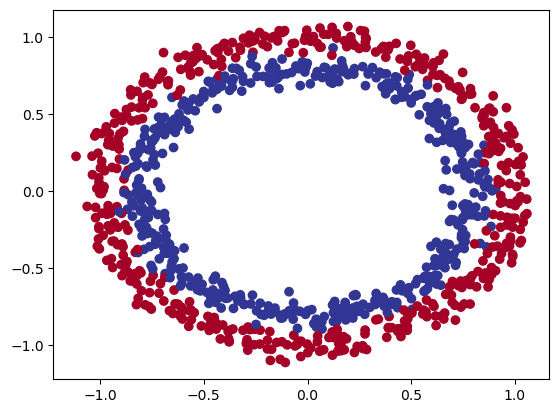

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.74220688 0.24668576] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [8]:
import torch

In [9]:
# set model to MPS if available, or GPU, otherwise default to CPU
if torch.backends.mps.is_available():
    device = "mps"
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = "cuda"
    print("GPU found")
else:
    device = "cpu"
    print ("Neither MPS device nor GPU found.")

MPS device found.


In [10]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7422,  0.2467],
         [-0.7340,  0.1687],
         [-0.8299,  0.2220],
         [-0.4291,  0.6722],
         [ 0.4456, -0.8949]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
# split train & test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
from torch import nn

In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        
        # x is 2d, 5 is hour hidden dimension, y is 1d
        self.layer_1 = nn.Linear(in_features=2, out_features=5, bias=True)
        self.layer_2 = nn.Linear(in_features=5, out_features=1, bias=True)
        # no need to say bias=True it's on by default
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [14]:
# create model instance & put it on device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# this is a quicker way to do the same thing 
# only works because a linear ff network is so simple
model_69 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_69

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Woah, that looks much simpler than subclassing `nn.Module`, why not just always use `nn.Sequential`?

`nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, it *always* runs in sequential order.

So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom `nn.Module` subclass.

In [16]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.0967],
        [0.0423],
        [0.2763],
        [0.0399],
        [0.3417],
        [0.3053],
        [0.0967],
        [0.1554],
        [0.2849],
        [0.0384]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Hmm, it seems there's the same amount of predictions as there is test labels but the predictions don't look like they're in the same form or shape as the test labels.

We've got a couple steps we can do to fix this, we'll see these later on.

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Mutli-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) | 
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

In [17]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.1)

In [18]:
# calc accuracy
def accuracy_fn(y_true, y_pred):
    # torch.eq checks when they're equivalent
    # .sum() sums the true values
    # not sure what .item() does
    correct = torch.eq(y_true, y_pred).sum().item()
    
    acc = (correct / len(y_pred)) *100
    return acc

# accuracy is nice cuz it's more understandable than loss

In [19]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0967],
        [0.0423],
        [0.2763],
        [0.0399],
        [0.3417]], device='mps:0', grad_fn=<SliceBackward0>)

In [20]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5242],
        [0.5106],
        [0.5686],
        [0.5100],
        [0.5846]], device='mps:0', grad_fn=<SigmoidBackward0>)

* If `y_pred_probs` >= 0.5, `y=1` (class 1)
* If `y_pred_probs` < 0.5, `y=0` (class 0)

In [21]:
y_preds = torch.round(y_pred_probs)
y_preds.shape, y_preds[:5]

(torch.Size([5, 1]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], device='mps:0', grad_fn=<SliceBackward0>))

In [22]:
y_preds.squeeze() # get rid of extra dimension

tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [24]:
torch.manual_seed(42)

epochs = 1000

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### training
    model_0.train()
    
    # fwd pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # calc loss & accuracy
    loss = loss_fn(y_logits,
                  y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    
    # set optimizer w zero grad
    optimizer.zero_grad()
    
    # calc the gradient
    loss.backward()
    
    # perform backprop
    optimizer.step()
    
    ### testing
    model_0.eval()
    
    with torch.inference_mode():
        # fwd pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # calc loss/accuracy
        test_loss = loss_fn(test_logits,
                           y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)
        
    if epoch % 10 == 0 or epoch == 999:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70139, Accuracy: 50.00% | Test loss: 0.69522, Test acc: 50.00%
Epoch: 10 | Loss: 0.69763, Accuracy: 58.75% | Test loss: 0.69241, Test acc: 56.50%
Epoch: 20 | Loss: 0.69606, Accuracy: 53.12% | Test loss: 0.69144, Test acc: 53.50%
Epoch: 30 | Loss: 0.69532, Accuracy: 50.50% | Test loss: 0.69115, Test acc: 53.00%
Epoch: 40 | Loss: 0.69492, Accuracy: 50.50% | Test loss: 0.69111, Test acc: 54.00%
Epoch: 50 | Loss: 0.69465, Accuracy: 50.00% | Test loss: 0.69116, Test acc: 53.00%
Epoch: 60 | Loss: 0.69444, Accuracy: 50.12% | Test loss: 0.69125, Test acc: 54.50%
Epoch: 70 | Loss: 0.69428, Accuracy: 50.12% | Test loss: 0.69136, Test acc: 54.00%
Epoch: 80 | Loss: 0.69414, Accuracy: 49.75% | Test loss: 0.69147, Test acc: 53.50%
Epoch: 90 | Loss: 0.69401, Accuracy: 49.88% | Test loss: 0.69158, Test acc: 53.00%
Epoch: 100 | Loss: 0.69390, Accuracy: 49.62% | Test loss: 0.69170, Test acc: 53.00%
Epoch: 110 | Loss: 0.69381, Accuracy: 49.50% | Test loss: 0.69181, Test acc: 52.50%
Epo

Epoch: 990 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69463, Test acc: 45.50%
Epoch: 999 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69463, Test acc: 45.50%


looks like our model is randomly guessing which isn't too surprising given that you're asking a 5 node linear-only layer to approximate a 3d system with quadratics

In [25]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


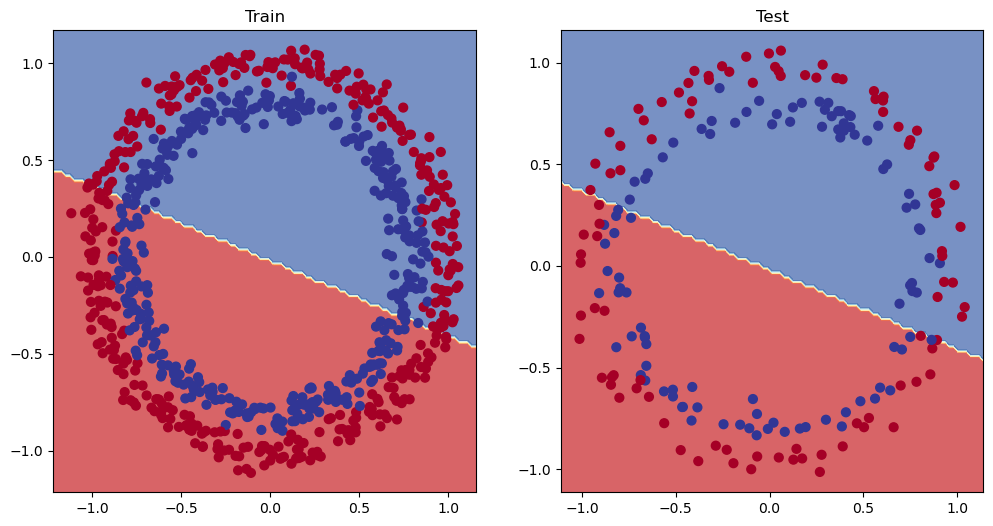

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is **underfitting**, meaning it's not learning predictive patterns from the data.

| Model improvement technique* | What does it do? |
| ----- | ----- |
| **Add more layers** | Each layer *potentially* increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network *deeper*. |
| **Add more hidden units** | Similar to the above, more hidden units per layer means a *potential* increase in learning capabilities of the model, more hidden units is often referred to as making your neural network *wider*. |
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data. |
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint). |
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough. |
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem. |
| **Use transfer learning** | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in [notebook 06](https://www.learnpytorch.io/06_pytorch_transfer_learning/). |

### Recreating non-linear data (red and blue circles)

First, let's recreate the data to start off fresh. We'll use the same setup as before. 

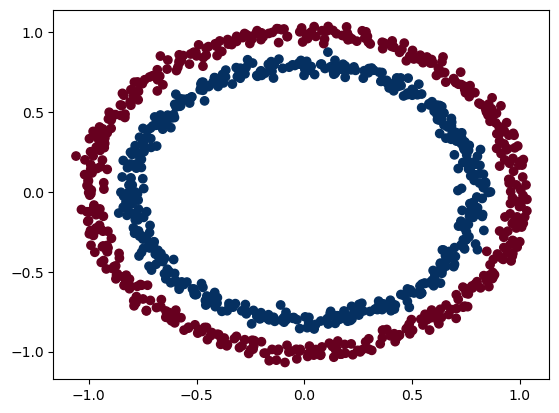

In [27]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [28]:
import torch
from torch import nn

# set model to MPS if available, or GPU, otherwise default to CPU
if torch.backends.mps.is_available():
    device = "mps"
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = "cuda"
    print("GPU found")
else:
    device = "cpu"
    print ("Neither MPS device nor GPU found.")

MPS device found.


In [29]:
# Convert to tensors and split into train and test sets
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [30]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=20)
        self.layer_3 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV1().to(device)
print(model_1)

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


In [31]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [32]:
# calc accuracy
def accuracy_fn(y_true, y_pred):
    # torch.eq checks when they're equivalent
    # .sum() sums the true values
    # not sure what .item() does
    correct = torch.eq(y_true, y_pred).sum().item()
    
    acc = (correct / len(y_pred)) *100
    return acc

In [33]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      
        # 2. Calcuate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0 or epoch == 999:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69448, Accuracy: 47.62% | Test Loss: 0.69197, Test Accuracy: 54.00%
Epoch: 100 | Loss: 0.69102, Accuracy: 53.12% | Test Loss: 0.68961, Test Accuracy: 56.50%
Epoch: 200 | Loss: 0.68750, Accuracy: 56.88% | Test Loss: 0.68704, Test Accuracy: 57.00%
Epoch: 300 | Loss: 0.68379, Accuracy: 59.62% | Test Loss: 0.68357, Test Accuracy: 59.50%
Epoch: 400 | Loss: 0.67821, Accuracy: 63.12% | Test Loss: 0.67807, Test Accuracy: 63.00%
Epoch: 500 | Loss: 0.66898, Accuracy: 69.50% | Test Loss: 0.66913, Test Accuracy: 72.00%
Epoch: 600 | Loss: 0.65292, Accuracy: 75.38% | Test Loss: 0.65433, Test Accuracy: 77.00%
Epoch: 700 | Loss: 0.62314, Accuracy: 85.62% | Test Loss: 0.62753, Test Accuracy: 84.00%
Epoch: 800 | Loss: 0.56539, Accuracy: 94.62% | Test Loss: 0.57623, Test Accuracy: 94.00%
Epoch: 900 | Loss: 0.45988, Accuracy: 99.38% | Test Loss: 0.48168, Test Accuracy: 98.00%
Epoch: 999 | Loss: 0.31254, Accuracy: 99.75% | Test Loss: 0.34370, Test Accuracy: 100.00%


Remember how our circle data is non-linear? Well, let's see how our models predictions look now the model's been trained with non-linear activation functions.

In [34]:
# Make predictions
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

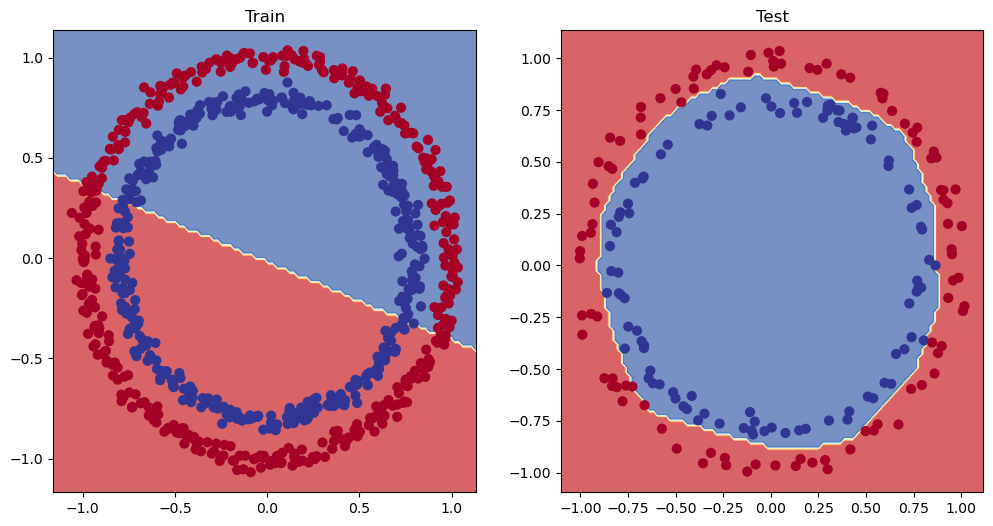

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_0 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # model_1 = has non-linearity

# Creating mutli-class classification data & model

In [1]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# set model to MPS if available, or GPU, otherwise default to CPU
if torch.backends.mps.is_available():
    device = "mps"
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = "cuda"
    print("GPU found")
else:
    device = "cpu"
    print ("Neither MPS device nor GPU found.")

#device = "cpu"

MPS device found.


tensor([[-6.5164, -5.1317],
        [-8.3806,  2.3424],
        [ 5.3431,  5.7273],
        [-9.7810, -9.7540],
        [ 0.9222,  1.1136]]) tensor([0, 3, 1, 0, 2])


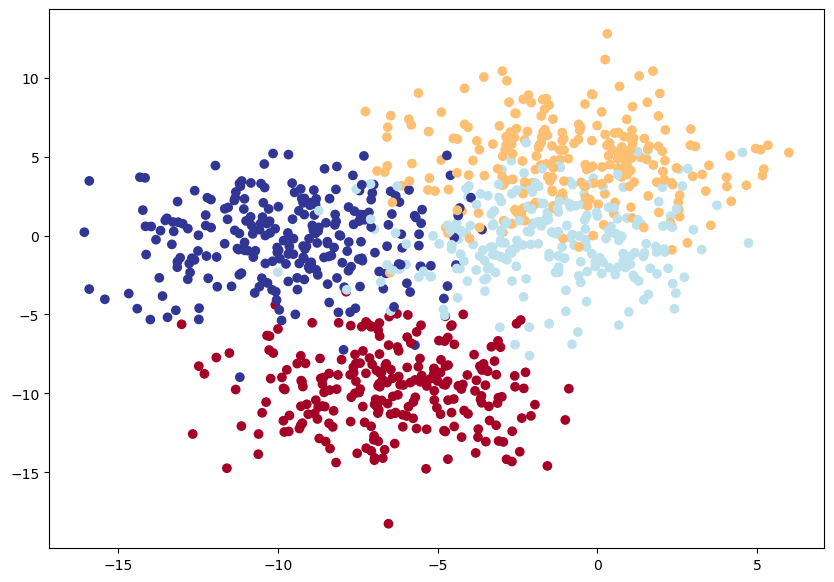

In [3]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 11

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=2.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [4]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 12.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
# Create loss and optimizer
#loss_fn = nn.CrossEntropyLoss() # this was causing my kernel to shutdown
loss_fn = nn.NLLLoss() # negative log likelihood loss
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

In [6]:
# calc accuracy
def accuracy_fn(y_true, y_pred):
    # torch.eq checks when they're equivalent
    # .sum() sums the true values
    # not sure what .item() does
    correct = torch.eq(y_true, y_pred).sum().item()
    
    acc = (correct / len(y_pred)) *100
    return acc

In [7]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[0.1809, 0.1872, 0.2491, 0.6975],
        [0.2656, 0.5967, 0.6643, 1.6159],
        [0.4602, 0.7214, 1.0350, 2.1484],
        [0.5068, 0.5661, 0.9914, 1.9181],
        [0.5437, 0.9307, 1.3055, 2.6782]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [8]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [9]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[0.2860, 0.6531, 0.7342, 1.7554],
        [0.6439, 1.2575, 1.6842, 3.4601],
        [0.3416, 0.1048, 0.4226, 0.7789],
        [0.3782, 0.9437, 1.0754, 2.4554],
        [0.3214, 0.5608, 0.7194, 1.6300]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1197, 0.1728, 0.1874, 0.5202],
        [0.0447, 0.0825, 0.1264, 0.7465],
        [0.2261, 0.1785, 0.2452, 0.3502],
        [0.0784, 0.1381, 0.1575, 0.6260],
        [0.1340, 0.1703, 0.1996, 0.4961]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [10]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='mps:0', grad_fn=<SumBackward0>)

In [11]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1197, 0.1728, 0.1874, 0.5202], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='mps:0')


In [12]:
torch.manual_seed(69)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train).squeeze() # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. reset grad
    optimizer.zero_grad()

    # 4. calc grad
    loss.backward()

    # 5. do backprop
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test).squeeze()
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0 or epoch == 99:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.19347, Acc: 47.50% | Test Loss: 0.93451, Test Acc: 69.00%
Epoch: 10 | Loss: 0.64106, Acc: 71.12% | Test Loss: 0.59266, Test Acc: 72.50%
Epoch: 20 | Loss: 0.54744, Acc: 78.25% | Test Loss: 0.50389, Test Acc: 79.00%
Epoch: 30 | Loss: 0.47879, Acc: 82.88% | Test Loss: 0.43332, Test Acc: 85.50%
Epoch: 40 | Loss: 0.42963, Acc: 84.25% | Test Loss: 0.38285, Test Acc: 87.50%
Epoch: 50 | Loss: 0.39879, Acc: 85.38% | Test Loss: 0.35181, Test Acc: 88.50%
Epoch: 60 | Loss: 0.38015, Acc: 85.50% | Test Loss: 0.33352, Test Acc: 89.00%
Epoch: 70 | Loss: 0.36841, Acc: 85.62% | Test Loss: 0.32226, Test Acc: 89.00%
Epoch: 80 | Loss: 0.36050, Acc: 86.12% | Test Loss: 0.31479, Test Acc: 88.50%
Epoch: 90 | Loss: 0.35480, Acc: 86.00% | Test Loss: 0.30942, Test Acc: 88.50%
Epoch: 99 | Loss: 0.35083, Acc: 86.12% | Test Loss: 0.30578, Test Acc: 88.50%


In [12]:
torch.manual_seed(69)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


In [13]:
### Training
model_4.train()

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [14]:
# 1. Forward pass
y_logits = model_4(X_blob_train) # model outputs raw logits 
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    

In [ ]:
# 2. Calculate loss and accuracy
loss = loss_fn(y_logits, y_blob_train) 

# ^ ugh so kernel crashes from this line even if i change the loss function. I guess no multi-class for me -\_- might switch to tensorflow if i run into another issue like this

In [ ]:
acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

In [17]:
# 3. reset grad
optimizer.zero_grad()

In [18]:
# 4. calc grad
loss.backward()

In [19]:
# 5. do backprop
optimizer.step()

In [20]:

    ### Testing
model_4.eval()

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [21]:
with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_4(X_blob_test).squeeze()

In [22]:
with torch.inference_mode():
    # 1. Forward pass
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

In [23]:
with torch.inference_mode():
    test_loss = loss_fn(test_logits, y_blob_test)

In [24]:
with torch.inference_mode():
    test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)